# Paper 1: Regularization Effectiveness Study - Enhanced Version
## Autoren: Katrin Nguyen & Nico Loss

### Research Question
**Does regularization (L1, L2, or combined) materially improve generalization performance compared to standard linear regression on the diamonds pricing dataset?**

### Table of Contents
1. **Setup & Imports**
2. **Data Loading & Exploratory Analysis**
3. **Data Preprocessing**
   - Missing Value Handling
   - Outlier Treatment
   - Feature Engineering
   - Train/Validation/Test Split
   - Feature Scaling
4. **Baseline Model (OLS)**
   - Model Training
   - Assumption Checking
   - Performance Metrics
5. **Regularization Models**
   - Ridge Regression (L2)
   - Lasso Regression (L1)
   - ElasticNet (L1 + L2)
6. **Experimental Analysis**
   - Learning Curves
   - Regularization Paths
   - Feature Importance
   - Model Comparison
7. **Statistical Testing**
   - Paired t-tests
   - Bootstrap Confidence Intervals
8. **Results & Conclusions**

## 1. Setup & Imports

In [1]:
# Standard library imports
from pathlib import Path
import warnings
import pickle
from datetime import datetime

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Data source
import kagglehub

# Machine Learning
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet,
    RidgeCV, LassoCV, ElasticNetCV, lasso_path, enet_path
)
from sklearn.model_selection import (
    train_test_split, cross_val_score, cross_validate,
    GridSearchCV, learning_curve, validation_curve,
    KFold, StratifiedKFold
)
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    mean_absolute_percentage_error, explained_variance_score
)
from sklearn.exceptions import ConvergenceWarning

# Statistical testing
from scipy import stats
from scipy.stats import ttest_rel, wilcoxon, normaltest, shapiro
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Suppress convergence warnings for cleaner output
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Matplotlib inline for Jupyter Notebooks
%matplotlib inline

# ====================
# REPRODUCIBILITY SETTINGS
# ====================
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# ====================
# EXPERIMENT PARAMETERS
# ====================
# Cross-validation settings
CV_FOLDS = 10
CV_SCORING = 'r2'
N_JOBS = -1

# Hyperparameter search ranges
ALPHA_RANGE = np.logspace(-5, 3, 50)
L1_RATIO_RANGE = np.linspace(0.1, 0.9, 9)

# Model parameters
MAX_ITER = 20000
TOL = 1e-4

# Bootstrap parameters
N_BOOTSTRAP = 1000
CONFIDENCE_LEVEL = 0.95

# ====================
# VISUALIZATION SETTINGS
# ====================
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 100
})

# Create output directories
output_dirs = ['Reports', 'Models', 'Figures', 'Data']
for dir_name in output_dirs:
    Path(dir_name).mkdir(exist_ok=True)

# Logging function
def log_step(message):
    """Print formatted log message with timestamp"""
    timestamp = datetime.now().strftime("%H:%M:%S")
    print(f"\n[{timestamp}] {'='*60}")
    print(f"[{timestamp}] {message}")
    print(f"[{timestamp}] {'='*60}")

log_step("Setup Complete - All libraries imported successfully")

D:\Master KDT\Semester 1\Angew KI\WorkspaceKDT\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



[14:08:24] ============================================================
[14:08:24] Setup Complete - All libraries imported successfully
[14:08:24] ============================================================


## 2. Data Loading & Initial Exploration

In [2]:
log_step("Loading Diamond Dataset from Kaggle")

# Download dataset
path = kagglehub.dataset_download("nancyalaswad90/diamonds-prices")
print(f"Dataset path: {path}")

# Load data
df_raw = pd.read_csv(path + "/Diamonds Prices2022.csv")

# Remove erroneous index column if present
if "Unnamed: 0" in df_raw.columns:
    df_raw.drop(columns=["Unnamed: 0"], inplace=True)

print(f"\nDataset shape: {df_raw.shape}")
print(f"Features: {df_raw.shape[1]}")
print(f"Samples: {df_raw.shape[0]:,}")

# Basic information
print("\nDataset Info:")
print(df_raw.info())

print("\nFirst 5 rows:")
display(df_raw.head())

print("\nStatistical Summary:")
display(df_raw.describe())

# Check for missing values
missing_values = df_raw.isnull().sum()
if missing_values.any():
    print("\nMissing Values:")
    print(missing_values[missing_values > 0])
else:
    print("\n✓ No missing values detected")


[14:08:24] ============================================================
[14:08:24] Loading Diamond Dataset from Kaggle
[14:08:24] ============================================================
Dataset path: C:\Users\nicol\.cache\kagglehub\datasets\nancyalaswad90\diamonds-prices\versions\4

Dataset shape: (53943, 10)
Features: 10
Samples: 53,943

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53943 entries, 0 to 53942
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53943 non-null  float64
 1   cut      53943 non-null  object 
 2   color    53943 non-null  object 
 3   clarity  53943 non-null  object 
 4   depth    53943 non-null  float64
 5   table    53943 non-null  float64
 6   price    53943 non-null  int64  
 7   x        53943 non-null  float64
 8   y        53943 non-null  float64
 9   z        53943 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB
None

First 

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75



Statistical Summary:


,carat,depth,table,price,x,y,z
count,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000
mean,0.797935,61.749322,57.457251,3932.734294,5.731158,5.734526,3.538730
std,0.473999,1.432626,2.234549,3989.338447,1.121730,1.142103,0.705679
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.000000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000



✓ No missing values detected


## 3. Comprehensive Data Preprocessing

In [3]:
class DiamondPreprocessor:
    """
    Comprehensive preprocessing pipeline for diamond data.
    Handles outliers, missing values, feature engineering, and encoding.
    """
    
    def __init__(self, outlier_method='iqr', outlier_threshold=3.0):
        self.outlier_method = outlier_method
        self.outlier_threshold = outlier_threshold
        self.encodings = None
        self.outlier_bounds = {}
        self.preprocessing_stats = {}
        
    def fit(self, df):
        """Fit preprocessing parameters on training data"""
        # Store ordinal encodings based on domain knowledge
        self.encodings = {
            'cut': {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5},
            'color': {'J': 1, 'I': 2, 'H': 3, 'G': 4, 'F': 5, 'E': 6, 'D': 7},
            'clarity': {'I1': 1, 'SI2': 2, 'SI1': 3, 'VS2': 4, 
                       'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8}
        }
        
        # Calculate outlier bounds for numerical features
        numerical_cols = ['carat', 'depth', 'table', 'x', 'y', 'z']
        for col in numerical_cols:
            if self.outlier_method == 'iqr':
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                self.outlier_bounds[col] = {
                    'lower': Q1 - self.outlier_threshold * IQR,
                    'upper': Q3 + self.outlier_threshold * IQR
                }
            elif self.outlier_method == 'zscore':
                mean = df[col].mean()
                std = df[col].std()
                self.outlier_bounds[col] = {
                    'lower': mean - self.outlier_threshold * std,
                    'upper': mean + self.outlier_threshold * std
                }
        
        return self
    
    def transform(self, df):
        """Apply preprocessing transformations"""
        df_clean = df.copy()
        initial_size = len(df_clean)
        
        # Track preprocessing steps
        steps_log = []
        
        # Step 1: Remove invalid dimensions
        invalid_dims = (df_clean['x'] <= 0) | (df_clean['y'] <= 0) | (df_clean['z'] <= 0)
        n_invalid = invalid_dims.sum()
        df_clean = df_clean[~invalid_dims]
        steps_log.append(f"Removed {n_invalid} rows with invalid dimensions")
        
        # Step 2: Handle outliers
        for col, bounds in self.outlier_bounds.items():
            outliers = (df_clean[col] < bounds['lower']) | (df_clean[col] > bounds['upper'])
            n_outliers = outliers.sum()
            df_clean = df_clean[~outliers]
            steps_log.append(f"Removed {n_outliers} outliers from {col}")
        
        # Step 3: Ordinal encoding for categorical variables
        for col, mapping in self.encodings.items():
            df_clean[f'{col}_encoded'] = df_clean[col].map(mapping)
            
            # Handle unknown categories
            n_unknown = df_clean[f'{col}_encoded'].isna().sum()
            if n_unknown > 0:
                # Use median imputation for unknown categories
                median_val = df_clean[f'{col}_encoded'].median()
                df_clean[f'{col}_encoded'].fillna(median_val, inplace=True)
                steps_log.append(f"Imputed {n_unknown} unknown {col} values with median")
        
        # Step 4: Feature Engineering
        # Volume-based features
        df_clean['volume'] = df_clean['x'] * df_clean['y'] * df_clean['z']
        df_clean['surface_area'] = 2 * (df_clean['x']*df_clean['y'] + 
                                        df_clean['y']*df_clean['z'] + 
                                        df_clean['x']*df_clean['z'])
        
        # Ratio features
        df_clean['xy_ratio'] = df_clean['x'] / df_clean['y']
        df_clean['xz_ratio'] = df_clean['x'] / df_clean['z']
        df_clean['depth_table_ratio'] = df_clean['depth'] / df_clean['table']
        
        # Polynomial features
        df_clean['carat_squared'] = df_clean['carat'] ** 2
        df_clean['carat_cubed'] = df_clean['carat'] ** 3
        
        # Interaction features
        df_clean['carat_cut_interaction'] = df_clean['carat'] * df_clean['cut_encoded']
        df_clean['volume_clarity_interaction'] = df_clean['volume'] * df_clean['clarity_encoded']
        
        # Quality index (composite feature)
        df_clean['quality_index'] = (df_clean['cut_encoded'] + 
                                     df_clean['color_encoded'] + 
                                     df_clean['clarity_encoded']) / 3
        
        steps_log.append("Added 11 engineered features")
        
        # Step 5: Drop original categorical columns
        df_clean = df_clean.drop(columns=['cut', 'color', 'clarity'])
        
        # Log preprocessing summary
        final_size = len(df_clean)
        print("\nPreprocessing Summary:")
        for step in steps_log:
            print(f"  • {step}")
        print(f"\nRows: {initial_size:,} → {final_size:,} ({final_size/initial_size*100:.1f}% retained)")
        print(f"Features: {df.shape[1]} → {df_clean.shape[1]}")
        
        return df_clean
    
    def fit_transform(self, df):
        """Fit and transform in one step"""
        return self.fit(df).transform(df)

### 3.1 Train-Validation-Test Split Strategy

In [4]:
log_step("Performing Train-Validation-Test Split")

# Split strategy: 60% train, 20% validation, 20% test
# Stratify by price quartiles to ensure price distribution consistency

# Create price quartiles for stratification
price_quartiles = pd.qcut(df_raw['price'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# First split: separate test set
X_temp = df_raw.drop('price', axis=1)
y_temp = df_raw['price']

X_train_val, X_test_raw, y_train_val, y_test_raw, strat_train_val, strat_test = train_test_split(
    X_temp, y_temp, price_quartiles,
    test_size=0.20,
    random_state=RANDOM_SEED,
    stratify=price_quartiles
)

# Second split: separate train and validation
strat_train_val_reset = pd.Series(strat_train_val.values)
X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(
    X_train_val, y_train_val,
    test_size=0.25,  # 0.25 of 0.80 = 0.20 of total
    random_state=RANDOM_SEED,
    stratify=strat_train_val_reset
)

print(f"Split Sizes:")
print(f"  • Training:   {len(X_train_raw):,} samples ({len(X_train_raw)/len(df_raw)*100:.1f}%)")
print(f"  • Validation: {len(X_val_raw):,} samples ({len(X_val_raw)/len(df_raw)*100:.1f}%)")
print(f"  • Test:       {len(X_test_raw):,} samples ({len(X_test_raw)/len(df_raw)*100:.1f}%)")

# Verify price distribution consistency
print("\nPrice Distribution Check:")
print(f"  • Train mean: ${y_train_raw.mean():,.2f} (std: ${y_train_raw.std():,.2f})")
print(f"  • Val mean:   ${y_val_raw.mean():,.2f} (std: ${y_val_raw.std():,.2f})")
print(f"  • Test mean:  ${y_test_raw.mean():,.2f} (std: ${y_test_raw.std():,.2f})")

# Combine X and y for preprocessing
train_df = pd.concat([X_train_raw, y_train_raw], axis=1)
val_df = pd.concat([X_val_raw, y_val_raw], axis=1)
test_df = pd.concat([X_test_raw, y_test_raw], axis=1)


[14:08:26] ============================================================
[14:08:26] Performing Train-Validation-Test Split
[14:08:26] ============================================================
Split Sizes:
  • Training:   32,365 samples (60.0%)
  • Validation: 10,789 samples (20.0%)
  • Test:       10,789 samples (20.0%)

Price Distribution Check:
  • Train mean: $3,924.36 (std: $3,972.47)
  • Val mean:   $3,934.54 (std: $3,993.47)
  • Test mean:  $3,956.05 (std: $4,035.70)


### 3.2 Apply Preprocessing Pipeline

In [5]:
log_step("Applying Preprocessing Pipeline")

# Initialize preprocessor
preprocessor = DiamondPreprocessor(outlier_method='iqr', outlier_threshold=3.0)

# Fit on training data and transform all sets
print("\n1. Processing Training Data:")
train_processed = preprocessor.fit_transform(train_df)

print("\n2. Processing Validation Data:")
val_processed = preprocessor.transform(val_df)

print("\n3. Processing Test Data:")
test_processed = preprocessor.transform(test_df)

# Separate features and target
y_train = train_processed['price']
X_train = train_processed.drop('price', axis=1)

y_val = val_processed['price']
X_val = val_processed.drop('price', axis=1)

y_test = test_processed['price']
X_test = test_processed.drop('price', axis=1)

print(f"\nFinal Dataset Shapes:")
print(f"  • X_train: {X_train.shape}")
print(f"  • X_val:   {X_val.shape}")
print(f"  • X_test:  {X_test.shape}")


[14:08:27] ============================================================
[14:08:27] Applying Preprocessing Pipeline
[14:08:27] ============================================================

1. Processing Training Data:

Preprocessing Summary:
  • Removed 13 rows with invalid dimensions
  • Removed 27 outliers from carat
  • Removed 166 outliers from depth
  • Removed 11 outliers from table
  • Removed 0 outliers from x
  • Removed 1 outliers from y
  • Removed 1 outliers from z
  • Added 11 engineered features

Rows: 32,365 → 32,146 (99.3% retained)
Features: 10 → 20

2. Processing Validation Data:

Preprocessing Summary:
  • Removed 5 rows with invalid dimensions
  • Removed 6 outliers from carat
  • Removed 57 outliers from depth
  • Removed 4 outliers from table
  • Removed 0 outliers from x
  • Removed 0 outliers from y
  • Removed 0 outliers from z
  • Added 11 engineered features

Rows: 10,789 → 10,717 (99.3% retained)
Features: 10 → 20

3. Processing Test Data:

Preprocessing Sum

### 3.3 Feature Scaling/Normalization

In [6]:
log_step("Feature Scaling using RobustScaler")

# Use RobustScaler for better handling of outliers
scaler = RobustScaler()

# Fit on training data only
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames for feature tracking
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Scaling Statistics (from training data):")
scaling_stats = pd.DataFrame({
    'Median': scaler.center_,
    'IQR': scaler.scale_
}, index=X_train.columns)
print(scaling_stats.head(10))

# Save preprocessed data and scaler
print("\nSaving preprocessed data and transformers...")
pickle.dump(preprocessor, open('Models/preprocessor.pkl', 'wb'))
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

# Save processed datasets
X_train_scaled.to_csv('Data/X_train_scaled.csv', index=False)
X_val_scaled.to_csv('Data/X_val_scaled.csv', index=False)
X_test_scaled.to_csv('Data/X_test_scaled.csv', index=False)
y_train.to_csv('Data/y_train.csv', index=False)
y_val.to_csv('Data/y_val.csv', index=False)
y_test.to_csv('Data/y_test.csv', index=False)

print("✓ Preprocessing complete!")


[14:08:27] ============================================================
[14:08:27] Feature Scaling using RobustScaler
[14:08:27] ============================================================
Scaling Statistics (from training data):
                     Median        IQR
carat              0.700000    0.64000
depth             61.800000    1.40000
table             57.000000    3.00000
x                  5.690000    1.83000
y                  5.710000    1.82000
z                  3.530000    1.12000
cut_encoded        4.000000    2.00000
color_encoded      4.000000    3.00000
clarity_encoded    4.000000    2.00000
volume           114.686269  106.01925

Saving preprocessed data and transformers...
✓ Preprocessing complete!


## 4. Baseline Model (Ordinary Least Squares)

In [7]:
log_step("Training Baseline OLS Model")

# Train baseline model
baseline_model = LinearRegression()
baseline_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred_baseline = baseline_model.predict(X_train_scaled)
y_val_pred_baseline = baseline_model.predict(X_val_scaled)
y_test_pred_baseline = baseline_model.predict(X_test_scaled)

# Calculate metrics
def calculate_metrics(y_true, y_pred, name=""):
    """Calculate comprehensive regression metrics"""
    metrics = {
        'R² Score': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
    }
    return pd.Series(metrics, name=name)

# Baseline performance
baseline_metrics = pd.DataFrame([
    calculate_metrics(y_train, y_train_pred_baseline, "Train"),
    calculate_metrics(y_val, y_val_pred_baseline, "Validation"),
    calculate_metrics(y_test, y_test_pred_baseline, "Test")
])

print("\nBaseline Model Performance:")
print(baseline_metrics.round(4))

# Calculate train-test gap
train_test_gap = baseline_metrics.loc['Train', 'R² Score'] - baseline_metrics.loc['Test', 'R² Score']
print(f"\nTrain-Test R² Gap: {train_test_gap:.4f}")
if train_test_gap > 0.05:
    print("⚠️  Significant overfitting detected (gap > 0.05)")
else:
    print("✓ Model generalizes well (gap ≤ 0.05)")


[14:08:29] ============================================================
[14:08:29] Training Baseline OLS Model
[14:08:29] ============================================================

Baseline Model Performance:
            R² Score      RMSE       MAE     MAPE  Explained Variance
Train         0.9445  933.1352  595.6250  27.6805              0.9445
Validation    0.9467  919.8817  590.5765  27.6867              0.9467
Test          0.9485  913.5186  592.4641  28.0145              0.9486

Train-Test R² Gap: -0.0040
✓ Model generalizes well (gap ≤ 0.05)


### 4.1 OLS Assumption Checking


[14:08:29] ============================================================
[14:08:29] Checking OLS Assumptions
[14:08:29] ============================================================


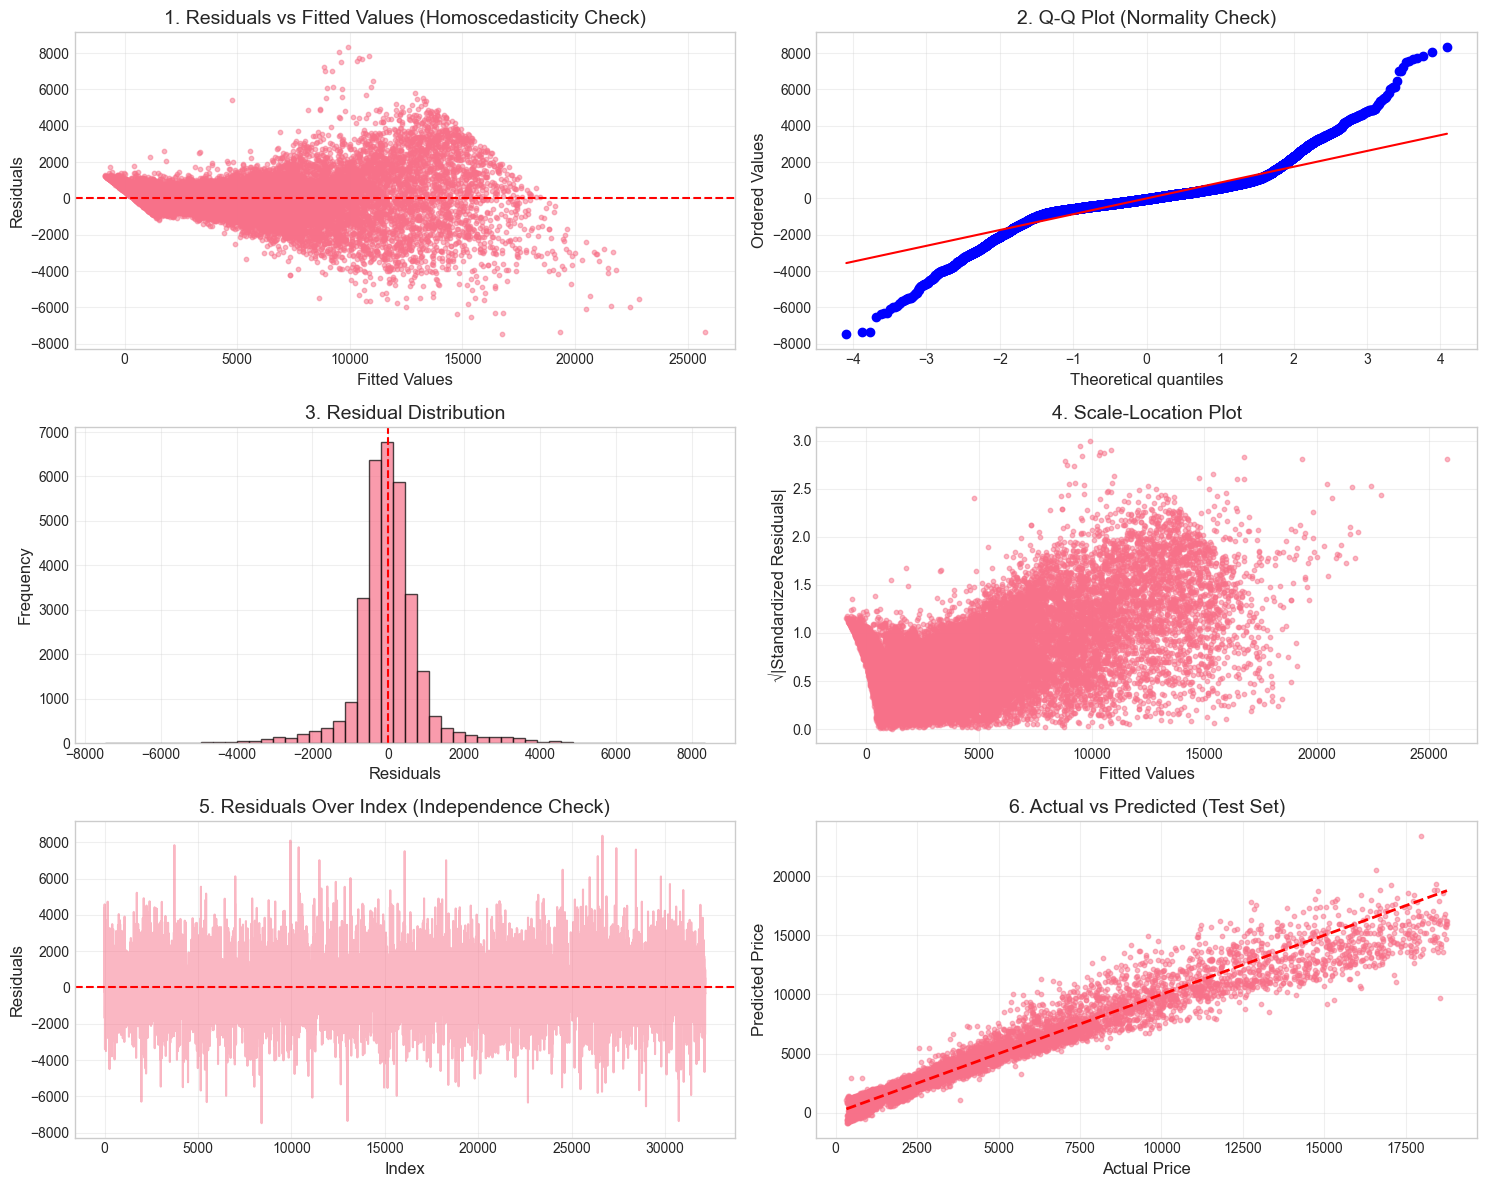


Statistical Tests for Assumptions:
1. Shapiro-Wilk Normality Test:
   Statistic: 0.8612, p-value: 0.0000
   ✗ Residuals are not normally distributed

2. Breusch-Pagan Test for Homoscedasticity:
   LM Statistic: 9235.6162, p-value: 0.0000
   ✗ Heteroscedasticity detected

3. Durbin-Watson Test for Autocorrelation:
   Statistic: 1.9814
   ✓ No autocorrelation

4. Variance Inflation Factors (Multicollinearity):


D:\Master KDT\Semester 1\Angew KI\WorkspaceKDT\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


            Feature           VIF
18    quality_index           inf
6       cut_encoded           inf
8   clarity_encoded           inf
7     color_encoded           inf
10     surface_area  2.455689e+05
9            volume  8.895528e+04
3                 x  2.013373e+04
4                 y  1.387765e+04
14    carat_squared  1.114893e+04
0             carat  8.151060e+03

⚠️  17 features have VIF > 10 (potential multicollinearity)


In [8]:
log_step("Checking OLS Assumptions")

# Calculate residuals
residuals_train = y_train - y_train_pred_baseline
residuals_test = y_test - y_test_pred_baseline

# Create diagnostic plots
fig = plt.figure(figsize=(15, 12))
gs = GridSpec(3, 2, figure=fig)

# 1. Residuals vs Fitted
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(y_train_pred_baseline, residuals_train, alpha=0.5, s=10)
ax1.axhline(y=0, color='r', linestyle='--')
ax1.set_xlabel('Fitted Values')
ax1.set_ylabel('Residuals')
ax1.set_title('1. Residuals vs Fitted Values (Homoscedasticity Check)')
ax1.grid(True, alpha=0.3)

# 2. Q-Q Plot
ax2 = fig.add_subplot(gs[0, 1])
stats.probplot(residuals_train, dist="norm", plot=ax2)
ax2.set_title('2. Q-Q Plot (Normality Check)')
ax2.grid(True, alpha=0.3)

# 3. Histogram of Residuals
ax3 = fig.add_subplot(gs[1, 0])
ax3.hist(residuals_train, bins=50, edgecolor='black', alpha=0.7)
ax3.axvline(x=0, color='r', linestyle='--')
ax3.set_xlabel('Residuals')
ax3.set_ylabel('Frequency')
ax3.set_title('3. Residual Distribution')
ax3.grid(True, alpha=0.3)

# 4. Scale-Location Plot
ax4 = fig.add_subplot(gs[1, 1])
standardized_residuals = residuals_train / residuals_train.std()
ax4.scatter(y_train_pred_baseline, np.sqrt(np.abs(standardized_residuals)), alpha=0.5, s=10)
ax4.set_xlabel('Fitted Values')
ax4.set_ylabel('√|Standardized Residuals|')
ax4.set_title('4. Scale-Location Plot')
ax4.grid(True, alpha=0.3)

# 5. Residuals over time (index)
ax5 = fig.add_subplot(gs[2, 0])
ax5.plot(residuals_train.values, alpha=0.5)
ax5.axhline(y=0, color='r', linestyle='--')
ax5.set_xlabel('Index')
ax5.set_ylabel('Residuals')
ax5.set_title('5. Residuals Over Index (Independence Check)')
ax5.grid(True, alpha=0.3)

# 6. Actual vs Predicted
ax6 = fig.add_subplot(gs[2, 1])
ax6.scatter(y_test, y_test_pred_baseline, alpha=0.5, s=10)
ax6.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax6.set_xlabel('Actual Price')
ax6.set_ylabel('Predicted Price')
ax6.set_title('6. Actual vs Predicted (Test Set)')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Figures/ols_diagnostics.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistical tests for assumptions
print("\nStatistical Tests for Assumptions:")
print("="*50)

# 1. Normality Test (Shapiro-Wilk on sample)
sample_size = min(5000, len(residuals_train))  # Shapiro-Wilk is sensitive to large samples
residual_sample = np.random.choice(residuals_train, sample_size, replace=False)
stat, p_value = shapiro(residual_sample)
print(f"1. Shapiro-Wilk Normality Test:")
print(f"   Statistic: {stat:.4f}, p-value: {p_value:.4f}")
print(f"   {'✓' if p_value > 0.05 else '✗'} Residuals are {'normally' if p_value > 0.05 else 'not normally'} distributed")

# 2. Breusch-Pagan Test for Homoscedasticity
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
X_train_with_const = sm.add_constant(X_train_scaled)
bp_test = het_breuschpagan(residuals_train, X_train_with_const)
print(f"\n2. Breusch-Pagan Test for Homoscedasticity:")
print(f"   LM Statistic: {bp_test[0]:.4f}, p-value: {bp_test[1]:.4f}")
print(f"   {'✓' if bp_test[1] > 0.05 else '✗'} {'Homoscedasticity' if bp_test[1] > 0.05 else 'Heteroscedasticity'} detected")

# 3. Durbin-Watson Test for Autocorrelation
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuals_train)
print(f"\n3. Durbin-Watson Test for Autocorrelation:")
print(f"   Statistic: {dw_stat:.4f}")
print(f"   {'✓' if 1.5 < dw_stat < 2.5 else '✗'} {'No' if 1.5 < dw_stat < 2.5 else 'Potential'} autocorrelation")

# 4. VIF for Multicollinearity
print(f"\n4. Variance Inflation Factors (Multicollinearity):")
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled.values, i) 
                   for i in range(len(X_train_scaled.columns))]
vif_data = vif_data.sort_values('VIF', ascending=False)
print(vif_data.head(10))
high_vif = vif_data[vif_data['VIF'] > 10]
if len(high_vif) > 0:
    print(f"\n⚠️  {len(high_vif)} features have VIF > 10 (potential multicollinearity)")
else:
    print("\n✓ No severe multicollinearity detected (all VIF < 10)")

## 5. Regularization Models

### 5.1 Ridge Regression (L2 Regularization)

In [9]:
log_step("Ridge Regression - Hyperparameter Tuning")

# Create cross-validation object
kfold = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_SEED)

# Ridge with built-in CV
ridge_cv = RidgeCV(
    alphas=ALPHA_RANGE,
    cv=kfold,
    scoring='neg_mean_squared_error'
)

# Fit model
ridge_cv.fit(X_train_scaled, y_train)

# Best alpha
best_alpha_ridge = ridge_cv.alpha_
print(f"Optimal α for Ridge: {best_alpha_ridge:.6f}")

# Train final model with best alpha
ridge_best = Ridge(alpha=best_alpha_ridge, max_iter=MAX_ITER)
ridge_best.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_ridge = ridge_best.predict(X_train_scaled)
y_val_pred_ridge = ridge_best.predict(X_val_scaled)
y_test_pred_ridge = ridge_best.predict(X_test_scaled)

# Performance metrics
ridge_metrics = pd.DataFrame([
    calculate_metrics(y_train, y_train_pred_ridge, "Train"),
    calculate_metrics(y_val, y_val_pred_ridge, "Validation"),
    calculate_metrics(y_test, y_test_pred_ridge, "Test")
])

print("\nRidge Regression Performance:")
print(ridge_metrics.round(4))

# Compare to baseline
improvement = ridge_metrics.loc['Test', 'R² Score'] - baseline_metrics.loc['Test', 'R² Score']
print(f"\nImprovement over OLS: {improvement:.4f} ({improvement/baseline_metrics.loc['Test', 'R² Score']*100:.2f}%)")


[14:08:36] ============================================================
[14:08:36] Ridge Regression - Hyperparameter Tuning
[14:08:36] ============================================================
Optimal α for Ridge: 0.082864

Ridge Regression Performance:
            R² Score      RMSE       MAE     MAPE  Explained Variance
Train         0.9445  933.3146  595.5303  27.6776              0.9445
Validation    0.9466  920.5381  590.7585  27.7255              0.9467
Test          0.9486  913.0352  592.1625  28.0189              0.9486

Improvement over OLS: 0.0001 (0.01%)


### 5.2 Lasso Regression (L1 Regularization)

In [10]:
log_step("Lasso Regression - Hyperparameter Tuning")

# Lasso with built-in CV
lasso_cv = LassoCV(
    alphas=ALPHA_RANGE,
    cv=kfold,
    max_iter=MAX_ITER,
    n_jobs=N_JOBS,
    random_state=RANDOM_SEED
)

# Fit model
lasso_cv.fit(X_train_scaled, y_train)

# Best alpha
best_alpha_lasso = lasso_cv.alpha_
print(f"Optimal α for Lasso: {best_alpha_lasso:.6f}")

# Train final model
lasso_best = Lasso(alpha=best_alpha_lasso, max_iter=MAX_ITER)
lasso_best.fit(X_train_scaled, y_train)

# Feature selection behavior
n_features_selected = np.sum(lasso_best.coef_ != 0)
print(f"\nFeature Selection:")
print(f"  • Features selected: {n_features_selected}/{len(X_train_scaled.columns)}")
print(f"  • Features eliminated: {len(X_train_scaled.columns) - n_features_selected}")

# Show eliminated features
eliminated_features = X_train_scaled.columns[lasso_best.coef_ == 0]
if len(eliminated_features) > 0:
    print(f"\nEliminated features:")
    for feat in eliminated_features:
        print(f"    - {feat}")

# Predictions
y_train_pred_lasso = lasso_best.predict(X_train_scaled)
y_val_pred_lasso = lasso_best.predict(X_val_scaled)
y_test_pred_lasso = lasso_best.predict(X_test_scaled)

# Performance metrics
lasso_metrics = pd.DataFrame([
    calculate_metrics(y_train, y_train_pred_lasso, "Train"),
    calculate_metrics(y_val, y_val_pred_lasso, "Validation"),
    calculate_metrics(y_test, y_test_pred_lasso, "Test")
])

print("\nLasso Regression Performance:")
print(lasso_metrics.round(4))

# Compare to baseline
improvement = lasso_metrics.loc['Test', 'R² Score'] - baseline_metrics.loc['Test', 'R² Score']
print(f"\nImprovement over OLS: {improvement:.4f} ({improvement/baseline_metrics.loc['Test', 'R² Score']*100:.2f}%)")


[14:08:44] ============================================================
[14:08:44] Lasso Regression - Hyperparameter Tuning
[14:08:44] ============================================================
Optimal α for Lasso: 0.039069

Feature Selection:
  • Features selected: 19/19
  • Features eliminated: 0

Lasso Regression Performance:
            R² Score      RMSE       MAE     MAPE  Explained Variance
Train         0.9445  933.6315  595.5749  27.6786              0.9445
Validation    0.9466  921.1040  590.9548  27.7527              0.9466
Test          0.9486  912.9264  592.0440  28.0228              0.9486

Improvement over OLS: 0.0001 (0.01%)


### 5.3 ElasticNet (L1 + L2 Regularization)

In [11]:
log_step("ElasticNet - Grid Search for Optimal Hyperparameters")

# Grid search for ElasticNet
elastic_params = {
    'alpha': ALPHA_RANGE[::10],  # Sample every 10th alpha for efficiency
    'l1_ratio': L1_RATIO_RANGE
}

print(f"Grid Search Space:")
print(f"  • Alpha values: {len(elastic_params['alpha'])}")
print(f"  • L1 ratio values: {len(elastic_params['l1_ratio'])}")
print(f"  • Total combinations: {len(elastic_params['alpha']) * len(elastic_params['l1_ratio'])}")

elastic_grid = GridSearchCV(
    ElasticNet(max_iter=MAX_ITER, random_state=RANDOM_SEED),
    elastic_params,
    cv=kfold,
    scoring='r2',
    n_jobs=N_JOBS,
    verbose=1
)

# Fit grid search
elastic_grid.fit(X_train_scaled, y_train)

# Best parameters
print(f"\nOptimal ElasticNet parameters:")
print(f"  • α (alpha): {elastic_grid.best_params_['alpha']:.6f}")
print(f"  • l1_ratio: {elastic_grid.best_params_['l1_ratio']:.2f}")
print(f"  • Best CV score: {elastic_grid.best_score_:.4f}")

# Extract best model
elastic_best = elastic_grid.best_estimator_

# Feature selection behavior
n_features_selected = np.sum(elastic_best.coef_ != 0)
print(f"\nFeature Selection:")
print(f"  • Features selected: {n_features_selected}/{len(X_train_scaled.columns)}")

# Predictions
y_train_pred_elastic = elastic_best.predict(X_train_scaled)
y_val_pred_elastic = elastic_best.predict(X_val_scaled)
y_test_pred_elastic = elastic_best.predict(X_test_scaled)

# Performance metrics
elastic_metrics = pd.DataFrame([
    calculate_metrics(y_train, y_train_pred_elastic, "Train"),
    calculate_metrics(y_val, y_val_pred_elastic, "Validation"),
    calculate_metrics(y_test, y_test_pred_elastic, "Test")
])

print("\nElasticNet Performance:")
print(elastic_metrics.round(4))

# Compare to baseline
improvement = elastic_metrics.loc['Test', 'R² Score'] - baseline_metrics.loc['Test', 'R² Score']
print(f"\nImprovement over OLS: {improvement:.4f} ({improvement/baseline_metrics.loc['Test', 'R² Score']*100:.2f}%)")


[14:15:48] ============================================================
[14:15:48] ElasticNet - Grid Search for Optimal Hyperparameters
[14:15:48] ============================================================
Grid Search Space:
  • Alpha values: 5
  • L1 ratio values: 9
  • Total combinations: 45
Fitting 10 folds for each of 45 candidates, totalling 450 fits

Optimal ElasticNet parameters:
  • α (alpha): 0.000010
  • l1_ratio: 0.90
  • Best CV score: 0.9443

Feature Selection:
  • Features selected: 19/19

ElasticNet Performance:
            R² Score      RMSE       MAE     MAPE  Explained Variance
Train         0.9445  933.5793  595.7799  27.6580              0.9445
Validation    0.9466  920.8272  591.1608  27.7330              0.9466
Test          0.9486  912.9267  592.3985  28.0077              0.9486

Improvement over OLS: 0.0001 (0.01%)


## 6. Experimental Analysis

### 6.1 Learning Curves


[14:36:39] ============================================================
[14:36:39] Generating Learning Curves
[14:36:39] ============================================================


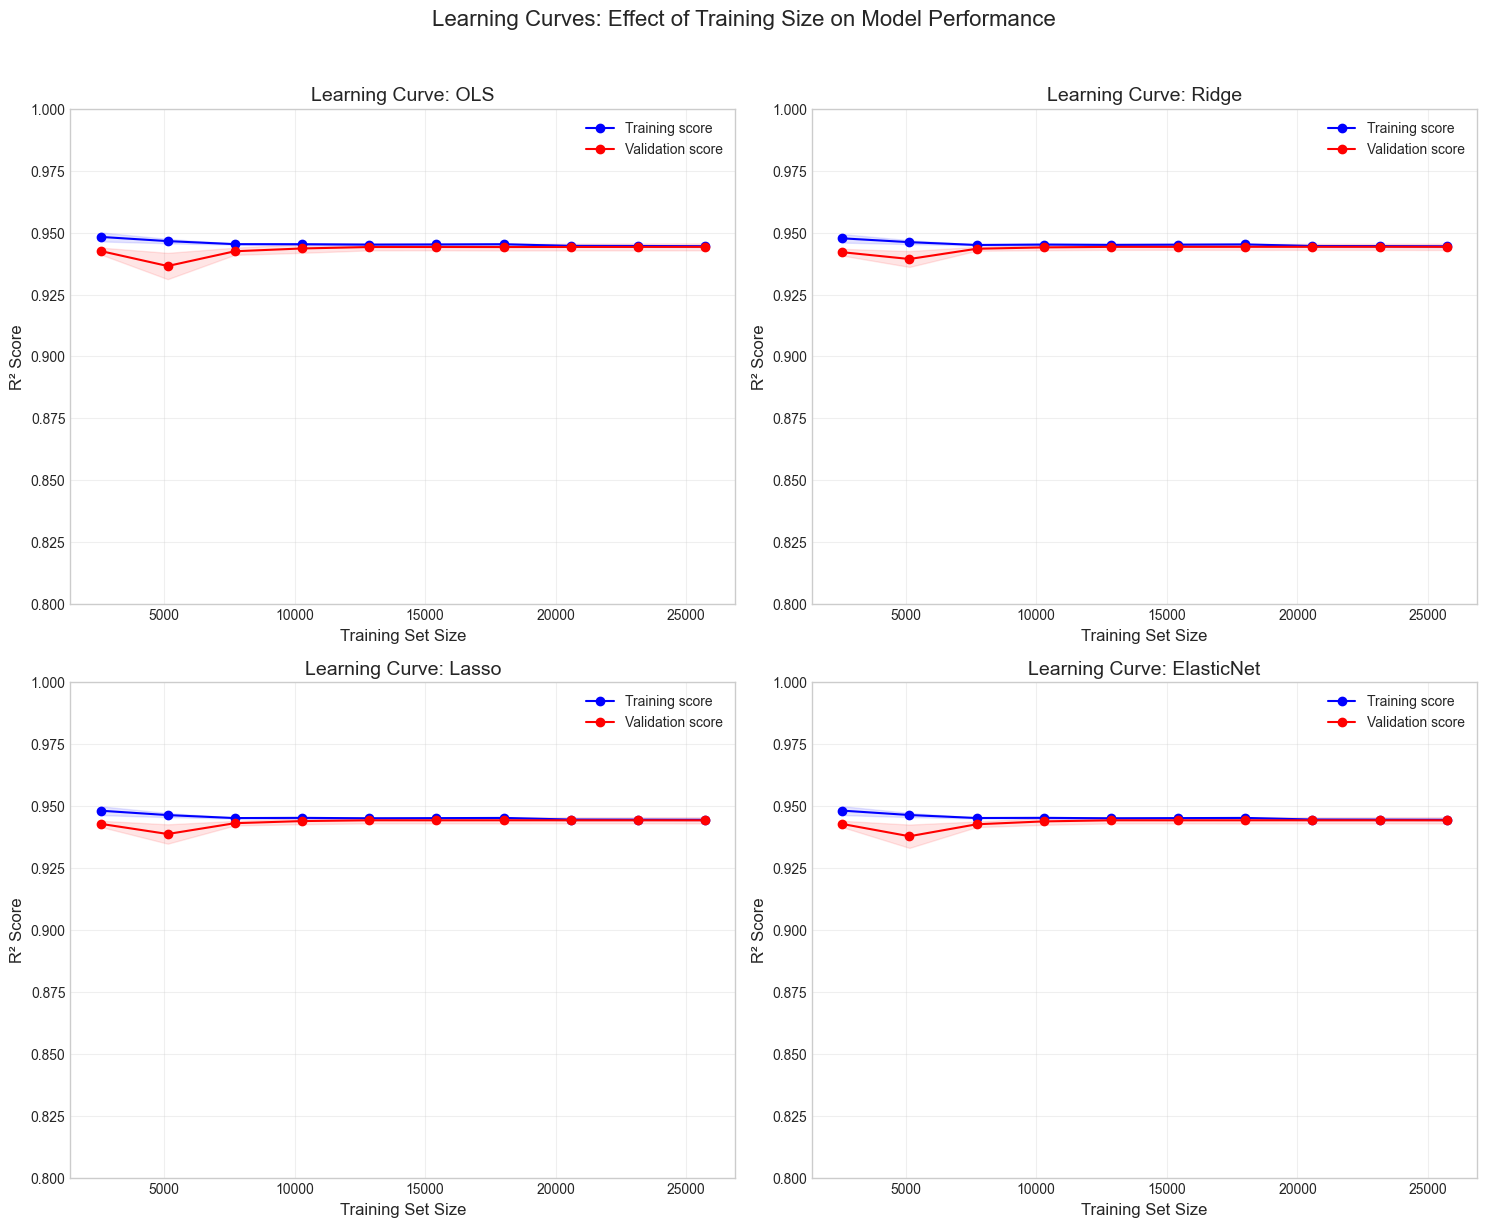

Learning curves analysis complete!


In [12]:
log_step("Generating Learning Curves")

# Define models for learning curves
models_dict = {
    'OLS': LinearRegression(),
    'Ridge': Ridge(alpha=best_alpha_ridge),
    'Lasso': Lasso(alpha=best_alpha_lasso, max_iter=MAX_ITER),
    'ElasticNet': elastic_best
}

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

train_sizes = np.linspace(0.1, 1.0, 10)

for idx, (name, model) in enumerate(models_dict.items()):
    ax = axes[idx]
    
    # Calculate learning curves
    train_sizes_abs, train_scores, val_scores = learning_curve(
        model, X_train_scaled, y_train,
        cv=5,
        train_sizes=train_sizes,
        scoring='r2',
        n_jobs=N_JOBS
    )
    
    # Calculate mean and std
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)
    
    # Plot learning curves
    ax.plot(train_sizes_abs, train_mean, 'o-', color='blue', label='Training score')
    ax.plot(train_sizes_abs, val_mean, 'o-', color='red', label='Validation score')
    
    # Add confidence bands
    ax.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, 
                     alpha=0.1, color='blue')
    ax.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, 
                     alpha=0.1, color='red')
    
    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('R² Score')
    ax.set_title(f'Learning Curve: {name}')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0.8, 1.0])

plt.suptitle('Learning Curves: Effect of Training Size on Model Performance', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('Figures/learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Learning curves analysis complete!")

### 6.2 Regularization Paths

In [14]:
log_step("Visualizing Regularization Paths")

# Calculate coefficients for different alpha values
alphas_for_path = np.logspace(-4, 2, 50)

"""
# Ridge path
ridge_coefs = []
for alpha in alphas_for_path:
    ridge_temp = Ridge(alpha=alpha)
    ridge_temp.fit(X_train_scaled, y_train)
    ridge_coefs.append(ridge_temp.coef_)
ridge_coefs = np.array(ridge_coefs)

# Lasso path
lasso_coefs = []
for alpha in alphas_for_path:
    lasso_temp = Lasso(alpha=alpha, max_iter=MAX_ITER)
    lasso_temp.fit(X_train_scaled, y_train)
    lasso_coefs.append(lasso_temp.coef_)
lasso_coefs = np.array(lasso_coefs)
"""

# 1. Ridge-Pfad (sauberer mit List Comprehension)
# Die Performance ist hier bereits gut, aber so ist der Code kürzer.
ridge_coefs = np.array([
    Ridge(alpha=alpha).fit(X_train_scaled, y_train).coef_
    for alpha in alphas_for_path
])

# 2. Lasso-Pfad (DEUTLICH SCHNELLER mit lasso_path)
# Ersetzt die gesamte langsame for-Schleife durch einen einzigen, optimierten Aufruf.
# Hinweis: lasso_path gibt die Koeffizienten transponiert zurück, daher .T am Ende.
_, lasso_coefs, _ = lasso_path(
    X_train_scaled,
    y_train,
    alphas=alphas_for_path,
    max_iter=MAX_ITER
)
lasso_coefs = lasso_coefs.T

# Elastic Net-Pfad
# Ersetzt die langsame for-Schleife durch einen einzigen, optimierten Aufruf.
_, enet_coefs, _ = enet_path(
    X_train_scaled,
    y_train,
    l1_ratio=elastic_grid.best_params_['l1_ratio'], # Wichtig: Den L1-Anteil angeben
    alphas=alphas_for_path,
    max_iter=MAX_ITER
)
enet_coefs = enet_coefs.T


# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Ridge path
ax1 = axes[0]
for i in range(ridge_coefs.shape[1]):
    ax1.plot(alphas_for_path, ridge_coefs[:, i], alpha=0.5)
ax1.axvline(x=best_alpha_ridge, color='red', linestyle='--', label=f'Optimal α = {best_alpha_ridge:.4f}')
ax1.set_xscale('log')
ax1.set_xlabel('Alpha (λ)')
ax1.set_ylabel('Coefficient Value')
ax1.set_title('Ridge Regularization Path')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Lasso path
ax2 = axes[1]
for i in range(lasso_coefs.shape[1]):
    ax2.plot(alphas_for_path, lasso_coefs[:, i], alpha=0.5)
ax2.axvline(x=best_alpha_lasso, color='red', linestyle='--', label=f'Optimal α = {best_alpha_lasso:.4f}')
ax2.set_xscale('log')
ax2.set_xlabel('Alpha (λ)')
ax2.set_ylabel('Coefficient Value')
ax2.set_title('Lasso Regularization Path (Feature Selection)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Regularization Paths: Coefficient Shrinkage Visualization', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('Figures/regularization_paths.png', dpi=300, bbox_inches='tight')
plt.show()

# Count features that go to zero in Lasso
n_zeros_by_alpha = (lasso_coefs == 0).sum(axis=1)
print(f"\nLasso feature elimination by alpha:")
for i in [0, len(alphas_for_path)//4, len(alphas_for_path)//2, 3*len(alphas_for_path)//4, -1]:
    print(f"  α = {alphas_for_path[i]:.4f}: {n_zeros_by_alpha[i]} features eliminated")


[15:27:46] ============================================================
[15:27:46] Visualizing Regularization Paths
[15:27:46] ============================================================


NameError: name 'lasso_path' is not defined

### 6.3 Feature Importance Analysis

In [ ]:
log_step("Analyzing Feature Importance")

# Collect coefficients from all models
feature_importance_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'OLS': baseline_model.coef_,
    'Ridge': ridge_best.coef_,
    'Lasso': lasso_best.coef_,
    'ElasticNet': elastic_best.coef_
})

# Calculate absolute importance
for model in ['OLS', 'Ridge', 'Lasso', 'ElasticNet']:
    feature_importance_df[f'{model}_abs'] = np.abs(feature_importance_df[model])

# Sort by average absolute importance
feature_importance_df['avg_abs_importance'] = feature_importance_df[['OLS_abs', 'Ridge_abs', 
                                                                     'Lasso_abs', 'ElasticNet_abs']].mean(axis=1)
feature_importance_df = feature_importance_df.sort_values('avg_abs_importance', ascending=False)

# Display top features
print("\nTop 10 Most Important Features (by average absolute coefficient):")
print(feature_importance_df[['Feature', 'OLS', 'Ridge', 'Lasso', 'ElasticNet']].head(10))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

models = ['OLS', 'Ridge', 'Lasso', 'ElasticNet']
colors = ['blue', 'green', 'orange', 'red']

for idx, model in enumerate(models):
    ax = axes[idx]
    top_features = feature_importance_df.nlargest(15, f'{model}_abs')
    
    ax.barh(range(len(top_features)), top_features[model], color=colors[idx], alpha=0.7)
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['Feature'])
    ax.set_xlabel('Coefficient Value')
    ax.set_title(f'{model} - Top 15 Features')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add zero line
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

plt.suptitle('Feature Importance Across Models', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('Figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature selection comparison
print("\nFeature Selection Summary:")
print(f"  • Features retained by Lasso: {(lasso_best.coef_ != 0).sum()}/{len(X_train_scaled.columns)}")
print(f"  • Features retained by ElasticNet: {(elastic_best.coef_ != 0).sum()}/{len(X_train_scaled.columns)}")

# Save feature importance
feature_importance_df.to_csv('Reports/feature_importance.csv', index=False)
print("\n✓ Feature importance saved to Reports/feature_importance.csv")

### 6.4 Comprehensive Model Comparison

In [ ]:
log_step("Comprehensive Model Comparison")

# Compile all metrics
comparison_data = []

for model_name, metrics_df in [('OLS', baseline_metrics), 
                                ('Ridge', ridge_metrics), 
                                ('Lasso', lasso_metrics), 
                                ('ElasticNet', elastic_metrics)]:
    for dataset in ['Train', 'Validation', 'Test']:
        row = {'Model': model_name, 'Dataset': dataset}
        row.update(metrics_df.loc[dataset].to_dict())
        comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

# Pivot for better visualization
pivot_r2 = comparison_df.pivot(index='Model', columns='Dataset', values='R² Score')
pivot_rmse = comparison_df.pivot(index='Model', columns='Dataset', values='RMSE')
pivot_mae = comparison_df.pivot(index='Model', columns='Dataset', values='MAE')

print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)

print("\n1. R² Scores:")
print(pivot_r2.round(4))

print("\n2. RMSE:")
print(pivot_rmse.round(2))

print("\n3. MAE:")
print(pivot_mae.round(2))

# Calculate train-test gaps
print("\n4. Train-Test R² Gap (Overfitting Indicator):")
gaps = pivot_r2['Train'] - pivot_r2['Test']
for model in gaps.index:
    gap = gaps[model]
    status = "✓" if gap < 0.05 else "⚠️"
    print(f"  {status} {model}: {gap:.4f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. R² Score Comparison
ax1 = axes[0, 0]
pivot_r2.plot(kind='bar', ax=ax1)
ax1.set_title('R² Score Comparison')
ax1.set_ylabel('R² Score')
ax1.set_xlabel('Model')
ax1.legend(title='Dataset')
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0.9, 1.0])

# 2. RMSE Comparison
ax2 = axes[0, 1]
pivot_rmse.plot(kind='bar', ax=ax2)
ax2.set_title('RMSE Comparison')
ax2.set_ylabel('RMSE ($)')
ax2.set_xlabel('Model')
ax2.legend(title='Dataset')
ax2.grid(True, alpha=0.3)

# 3. Train-Test Gap
ax3 = axes[1, 0]
gaps.plot(kind='bar', ax=ax3, color=['green' if g < 0.05 else 'red' for g in gaps])
ax3.axhline(y=0.05, color='black', linestyle='--', label='Threshold')
ax3.set_title('Train-Test R² Gap (Overfitting Check)')
ax3.set_ylabel('R² Gap')
ax3.set_xlabel('Model')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Model Performance on Test Set
ax4 = axes[1, 1]
test_metrics = comparison_df[comparison_df['Dataset'] == 'Test'].set_index('Model')
test_metrics[['R² Score', 'Explained Variance']].plot(kind='bar', ax=ax4)
ax4.set_title('Test Set Performance')
ax4.set_ylabel('Score')
ax4.set_xlabel('Model')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Model Comparison', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('Figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Save comparison table
comparison_df.to_csv('Reports/model_comparison.csv', index=False)
print("\n✓ Model comparison saved to Reports/model_comparison.csv")

## 7. Statistical Significance Testing

In [ ]:
log_step("Statistical Significance Testing")

# Perform k-fold cross-validation to get multiple scores for statistical testing
print(f"Performing {CV_FOLDS}-fold cross-validation for statistical testing...\n")

cv_scores = {}
for model_name, model in models_dict.items():
    scores = cross_val_score(model, X_train_scaled, y_train, 
                            cv=CV_FOLDS, scoring='r2', n_jobs=N_JOBS)
    cv_scores[model_name] = scores
    print(f"{model_name}:")
    print(f"  Mean R² = {scores.mean():.4f} ± {scores.std():.4f}")
    print(f"  Min = {scores.min():.4f}, Max = {scores.max():.4f}")

# 1. Paired t-tests
print("\n" + "="*60)
print("PAIRED T-TESTS (comparing to OLS baseline)")
print("="*60)

for model_name in ['Ridge', 'Lasso', 'ElasticNet']:
    t_stat, p_value = ttest_rel(cv_scores[model_name], cv_scores['OLS'])
    print(f"\n{model_name} vs OLS:")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.6f}")
    
    # Effect size (Cohen's d)
    diff = cv_scores[model_name] - cv_scores['OLS']
    cohen_d = diff.mean() / diff.std()
    print(f"  Cohen's d: {cohen_d:.4f}")
    
    # Interpretation
    if p_value < 0.001:
        significance = "***"
    elif p_value < 0.01:
        significance = "**"
    elif p_value < 0.05:
        significance = "*"
    else:
        significance = "ns"
    
    if t_stat > 0 and p_value < 0.05:
        print(f"  → {model_name} is significantly better than OLS {significance}")
    elif t_stat < 0 and p_value < 0.05:
        print(f"  → OLS is significantly better than {model_name} {significance}")
    else:
        print(f"  → No significant difference (p ≥ 0.05)")

# 2. Bootstrap Confidence Intervals
print("\n" + "="*60)
print(f"BOOTSTRAP CONFIDENCE INTERVALS ({int(CONFIDENCE_LEVEL*100)}% CI for Test R²)")
print("="*60)

print(f"\nRunning {N_BOOTSTRAP} bootstrap iterations...")

bootstrap_scores = {model: [] for model in models_dict.keys()}

# Fit models once on full training data
fitted_models = {
    'OLS': baseline_model,
    'Ridge': ridge_best,
    'Lasso': lasso_best,
    'ElasticNet': elastic_best
}

for i in range(N_BOOTSTRAP):
    # Resample test set with replacement
    indices = np.random.choice(len(X_test_scaled), len(X_test_scaled), replace=True)
    X_boot = X_test_scaled.iloc[indices]
    y_boot = y_test.iloc[indices]
    
    # Calculate R² for each model
    for model_name, model in fitted_models.items():
        y_pred = model.predict(X_boot)
        bootstrap_scores[model_name].append(r2_score(y_boot, y_pred))

# Calculate confidence intervals
alpha = 1 - CONFIDENCE_LEVEL
lower_percentile = (alpha/2) * 100
upper_percentile = (1 - alpha/2) * 100

print("\nBootstrap Results:")
for model_name in models_dict.keys():
    scores = bootstrap_scores[model_name]
    ci_lower = np.percentile(scores, lower_percentile)
    ci_upper = np.percentile(scores, upper_percentile)
    ci_mean = np.mean(scores)
    ci_std = np.std(scores)
    
    print(f"\n{model_name}:")
    print(f"  Mean R²: {ci_mean:.4f} ± {ci_std:.4f}")
    print(f"  {int(CONFIDENCE_LEVEL*100)}% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(f"  CI Width: {ci_upper - ci_lower:.4f}")

# 3. Wilcoxon Signed-Rank Test (non-parametric alternative)
print("\n" + "="*60)
print("WILCOXON SIGNED-RANK TEST (non-parametric)")
print("="*60)

for model_name in ['Ridge', 'Lasso', 'ElasticNet']:
    stat, p_value = wilcoxon(cv_scores[model_name], cv_scores['OLS'])
    print(f"\n{model_name} vs OLS:")
    print(f"  Statistic: {stat:.4f}")
    print(f"  p-value: {p_value:.6f}")

# Visualization of statistical tests
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# CV Scores Distribution
ax1 = axes[0]
cv_scores_df = pd.DataFrame(cv_scores)
cv_scores_df.boxplot(ax=ax1)
ax1.set_ylabel('R² Score')
ax1.set_title(f'{CV_FOLDS}-Fold Cross-Validation Scores')
ax1.grid(True, alpha=0.3)

# Bootstrap Distributions
ax2 = axes[1]
for model_name in models_dict.keys():
    ax2.hist(bootstrap_scores[model_name], alpha=0.5, label=model_name, bins=30)
ax2.set_xlabel('R² Score')
ax2.set_ylabel('Frequency')
ax2.set_title(f'Bootstrap Distributions (n={N_BOOTSTRAP})')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Statistical Testing Visualization', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('Figures/statistical_testing.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Statistical testing complete!")

## 8. Results & Conclusions

In [ ]:
log_step("FINAL RESULTS & CONCLUSIONS")

# Best model selection based on test R²
test_r2_scores = {
    'OLS': baseline_metrics.loc['Test', 'R² Score'],
    'Ridge': ridge_metrics.loc['Test', 'R² Score'],
    'Lasso': lasso_metrics.loc['Test', 'R² Score'],
    'ElasticNet': elastic_metrics.loc['Test', 'R² Score']
}

best_model = max(test_r2_scores, key=test_r2_scores.get)
best_score = test_r2_scores[best_model]

print("\n" + "="*70)
print("BEST MODEL")
print("="*70)
print(f"\nBest Model: {best_model}")
print(f"Test R² Score: {best_score:.4f}")

if best_model == 'Ridge':
    print(f"Optimal α: {best_alpha_ridge:.6f}")
elif best_model == 'Lasso':
    print(f"Optimal α: {best_alpha_lasso:.6f}")
elif best_model == 'ElasticNet':
    print(f"Optimal α: {elastic_grid.best_params_['alpha']:.6f}")
    print(f"Optimal l1_ratio: {elastic_grid.best_params_['l1_ratio']:.2f}")

# Answer to research question
print("\n" + "="*70)
print("ANSWER TO RESEARCH QUESTION")
print("="*70)
print("\nDoes regularization materially improve generalization on the diamonds dataset?")
print("-" * 70)

# Calculate improvements
improvements = {
    'Ridge': test_r2_scores['Ridge'] - test_r2_scores['OLS'],
    'Lasso': test_r2_scores['Lasso'] - test_r2_scores['OLS'],
    'ElasticNet': test_r2_scores['ElasticNet'] - test_r2_scores['OLS']
}

max_improvement = max(improvements.values())
best_regularized = max(improvements, key=improvements.get)

# Material improvement threshold (1% R² improvement)
MATERIAL_THRESHOLD = 0.01

if max_improvement > MATERIAL_THRESHOLD:
    print(f"\n✓ YES - Regularization provides MATERIAL improvement")
    print(f"\nBest regularized model: {best_regularized}")
    for model, improvement in improvements.items():
        pct_improvement = (improvement/test_r2_scores['OLS']) * 100
        print(f"  • {model}: +{improvement:.4f} R² ({pct_improvement:+.2f}% relative improvement)")
elif max_improvement > 0:
    print(f"\n⚠️  MARGINAL - Regularization provides only marginal improvement")
    print(f"\nMax improvement: {max_improvement:.4f} R² (below {MATERIAL_THRESHOLD} threshold)")
    for model, improvement in improvements.items():
        print(f"  • {model}: {improvement:+.4f} R²")
else:
    print(f"\n✗ NO - Regularization does not improve performance")
    print(f"\nOLS performs equal or better than all regularized models")

# Key insights
print("\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)

insights = []

# Overfitting analysis
train_test_gaps = {
    'OLS': baseline_metrics.loc['Train', 'R² Score'] - baseline_metrics.loc['Test', 'R² Score'],
    'Ridge': ridge_metrics.loc['Train', 'R² Score'] - ridge_metrics.loc['Test', 'R² Score'],
    'Lasso': lasso_metrics.loc['Train', 'R² Score'] - lasso_metrics.loc['Test', 'R² Score'],
    'ElasticNet': elastic_metrics.loc['Train', 'R² Score'] - elastic_metrics.loc['Test', 'R² Score']
}

min_gap_model = min(train_test_gaps, key=train_test_gaps.get)
insights.append(f"1. Least overfitting: {min_gap_model} (train-test gap: {train_test_gaps[min_gap_model]:.4f})")

# Feature selection
n_features_lasso = (lasso_best.coef_ != 0).sum()
n_features_elastic = (elastic_best.coef_ != 0).sum()
insights.append(f"2. Feature selection: Lasso retained {n_features_lasso}/{len(X_train_scaled.columns)} features")
insights.append(f"   ElasticNet retained {n_features_elastic}/{len(X_train_scaled.columns)} features")

# Statistical significance
sig_better = []
for model in ['Ridge', 'Lasso', 'ElasticNet']:
    t_stat, p_value = ttest_rel(cv_scores[model], cv_scores['OLS'])
    if p_value < 0.05 and t_stat > 0:
        sig_better.append(model)

if sig_better:
    insights.append(f"3. Statistically significant improvements: {', '.join(sig_better)}")
else:
    insights.append("3. No statistically significant improvements over OLS")

# Model complexity vs performance trade-off
if max_improvement < 0.005:
    insights.append("4. Trade-off: Marginal performance gain may not justify added complexity")
else:
    insights.append("4. Trade-off: Performance gain justifies regularization complexity")

for insight in insights:
    print(f"\n{insight}")

# Save final report
print("\n" + "="*70)
print("SAVING FINAL RESULTS")
print("="*70)

# Create summary report
summary = {
    'Metric': ['Best Model', 'Test R²', 'Test RMSE', 'Test MAE', 
               'Train-Test Gap', 'Features Used', 'Statistical Significance'],
    'Value': [
        best_model,
        f"{best_score:.4f}",
        f"${ridge_metrics.loc['Test', 'RMSE'] if best_model == 'Ridge' else baseline_metrics.loc['Test', 'RMSE']:.2f}",
        f"${ridge_metrics.loc['Test', 'MAE'] if best_model == 'Ridge' else baseline_metrics.loc['Test', 'MAE']:.2f}",
        f"{train_test_gaps[best_model]:.4f}",
        f"{n_features_lasso if best_model == 'Lasso' else len(X_train_scaled.columns)}",
        "Yes" if best_model in sig_better else "No"
    ]
}

summary_df = pd.DataFrame(summary)
summary_df.to_csv('Reports/final_summary.csv', index=False)
print("\n✓ Final summary saved to Reports/final_summary.csv")

# Save all trained models
for name, model in fitted_models.items():
    pickle.dump(model, open(f'Models/{name.lower()}_model.pkl', 'wb'))
print("✓ All models saved to Models/ directory")

print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)
print("\nAll results, figures, and models have been saved successfully.")
print("Thank you for using this comprehensive regularization analysis notebook!")